<a href="https://colab.research.google.com/github/droumis/capuchin/blob/master/SteinmetzDataPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
from google.colab import files
import pandas as pd
import io
from scipy import stats


In [2]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [3]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [10, 10]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[1]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])


In [5]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

#create long list of every region
allregions = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl", "CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM",
                "CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST", "ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT",
                "APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI",
                "ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI", "BLA", "BMA", "EP", "EPd", "MEA"]

print(len(allregions))

72


In [88]:
#concatenate spiking from all sessions

#create vectors to store data
sessionN = alldat.shape[0]
allNeuronsRespRew = np.empty((0,250))
allNeuronsRespNoRew = np.empty((0,250))
allNeuronsNoGoCorr = np.empty((0,250))
allNeuronsNoGoIncorr = np.empty((0,250))
allLoc = np.empty((0))
sessionID = np.empty((0))
for s in range(0,sessionN):
    neurons = alldat[s]['spks']
    regions = alldat[s]['brain_area']
    response = alldat[s]['response']
    reward = alldat[s]['feedback_type']
    rightVis = alldat[s]['contrast_right']
    leftVis = alldat[s]['contrast_left']

    #parse trials to get mean neuron trace for different trial types
    rewardTrials = (reward == 1)
    punishTrials = (reward == -1)
    noGoTrials = (rightVis + leftVis == 0)
    goTrials = (rightVis + leftVis != 0)
    noGoCorrTrials = np.logical_and(noGoTrials == True, rewardTrials == True)
    noGoIncorrTrials = np.logical_and(noGoTrials == True,punishTrials == True)

    #get each neuron's average response to trial type
    neuronRespRew = np.mean(neurons[:,rewardTrials,:], axis=1)
    neuronRespNoRew = np.mean(neurons[:,punishTrials,:], axis=1)
    neuronNoGoCorr = np.mean(neurons[:,noGoCorrTrials,:], axis=1)
    neuronNoGoIncorr = np.mean(neurons[:,noGoIncorrTrials,:], axis=1)

    #store data in large concatenation matrices
    allNeuronsRespRew = np.append(allNeuronsRespRew, neuronRespRew, axis = 0)
    allNeuronsRespNoRew = np.append(allNeuronsRespNoRew, neuronRespNoRew, axis = 0)
    allNeuronsNoGoCorr = np.append(allNeuronsNoGoCorr, neuronNoGoCorr, axis = 0)
    allNeuronsNoGoIncorr = np.append(allNeuronsNoGoIncorr, neuronNoGoIncorr, axis = 0)
    allLoc = np.append(allLoc, regions, axis = 0)
    sessionID = np.append(sessionID, s*np.ones((len(regions))))


In [90]:
print("All neurons response with reward", allNeuronsRespRew.shape)
print("All locations", allLoc.shape)
print("All session IDs", sessionID.shape)
print(sessionID)


All neurons response with reward (33958, 250)
All locations (33958,)
All session IDs (33958,)
[ 0.  0.  0. ... 38. 38. 38.]


In [15]:
#combine and average activity within a region
def zscoreRegionActivity(allNeurons, allLoc, regions):
    regAvg = np.empty((len(regions), 250))
    
    #go through each possible region
    for r in range(0,len(regions)):
        currReg = regions[r]
        #find all neurons that were recorded in that region
        neuronidx = (allLoc == regions[r])

        #average across neurons to get a region average activity trace
        meanResp = np.mean(allNeurons[neuronidx,:], axis=0)

        # if a NaNs show up, tell me where
        if np.isnan(np.mean(meanResp)):
            print(r)
        regAvg[r,:] = meanResp

    #zscore the region traces
    regAvgZ = stats.zscore(regAvg, axis=1)
    print(regAvgZ.shape)
    return regAvgZ

In [16]:
#get zscored region traces for every region for each trial type
regAvgZRespRew = zscoreRegionActivity(allNeuronsRespRew, allLoc, allregions)
regAvgZRespNoRew = zscoreRegionActivity(allNeuronsRespNoRew, allLoc, allregions)
regAvgZNoGoCorr = zscoreRegionActivity(allNeuronsNoGoCorr, allLoc, allregions)
regAvgZNoGoIncorr = zscoreRegionActivity(allNeuronsNoGoIncorr, allLoc, allregions)

(72, 250)
(72, 250)
(72, 250)
(72, 250)


In [17]:
#check for nans
def checkForNaNs(regAvgZ):
    assert np.all(np.isfinite(regAvgZ))
    nanidx = np.isnan(regAvgZ)

    if np.any(nanidx):
        print("NaNs in data", nanidx)
        # regAvgZ = np.delete(regAvgZ, nanidx[0], axis=0)
        # allregions = np.delete(allregions, nanidx[0], axis=0)

In [18]:
#check each dataset for nans
checkForNaNs(regAvgZRespRew)
checkForNaNs(regAvgZRespNoRew)
checkForNaNs(regAvgZNoGoCorr)
checkForNaNs(regAvgZNoGoIncorr)

In [66]:
#do PCA on all regions for a given set of trials
def doPCAonRegions(regAvgZ, title):
    from sklearn.decomposition import PCA 

    #make a model with 40 components
    model = PCA(40)

    #fit the model and transform the data
    dataFit = model.fit_transform(regAvgZ.T)
    print(dataFit.shape)

    #find percent variance explained
    percentVar = np.cumsum(model.explained_variance_)/(np.sum(model.explained_variance_))
    plt.plot(percentVar)
    explVar = np.where(percentVar > .90)
    print(explVar[0][0])
    plt.axvline((explVar[0][0]))
    plt.title(title)
    plt.ylabel('% Var Explained')
    plt.xlabel('Principal Components')
    W = model.components_

    #return the number of PCs that explain 90% of the data, the transformed data, and the weights for each feature in each component
    return explVar[0][0], dataFit, W

(250, 70)
15


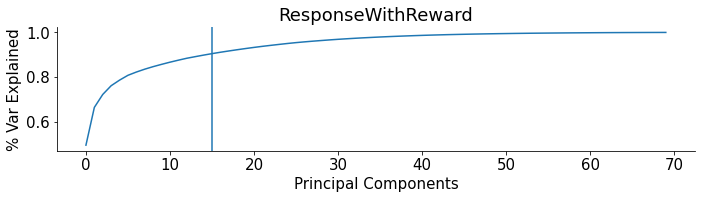

(250, 70)
30


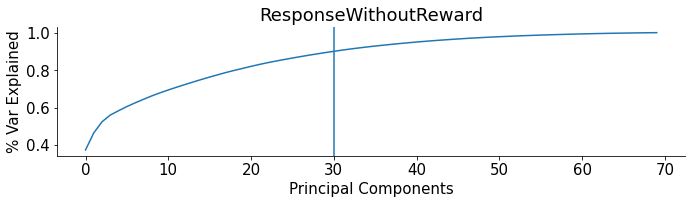

(250, 70)
40


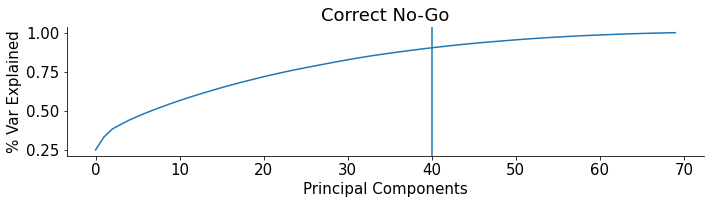

(250, 70)
37


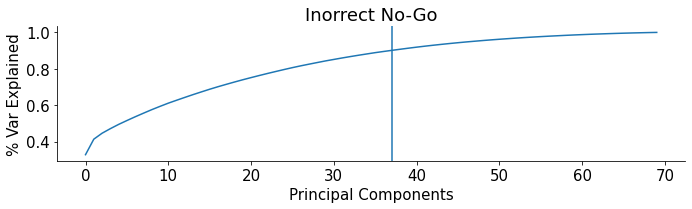

In [34]:
# do PCA on whole trial trace
plt.subplot(4,1,1)
resprewPCs, fitresprew, Wresprew = doPCAonRegions(regAvgZRespRew, 'ResponseWithReward')
plt.show()

plt.subplot(4,1,2)
respnorewPCs, fitrespnorew, Wrespnorew = doPCAonRegions(regAvgZRespNoRew, 'ResponseWithoutReward')
plt.show()

plt.subplot(4,1,3)
nogocorrPCs, fitnogocorr, Wnogocorr = doPCAonRegions(regAvgZNoGoCorr, 'Correct No-Go')
plt.show()

plt.subplot(4,1,4)
nogoincorrPCs, fitnogoincorr, Wnogoincorr = doPCAonRegions(regAvgZNoGoIncorr, 'Inorrect No-Go')
plt.show()

(40, 40)
9


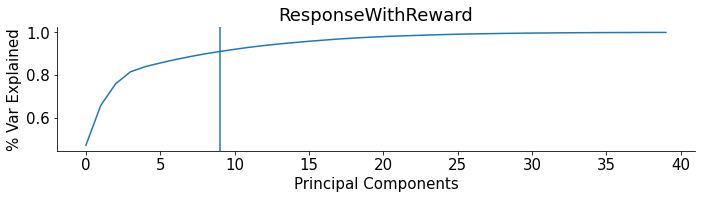

(40, 40)
17


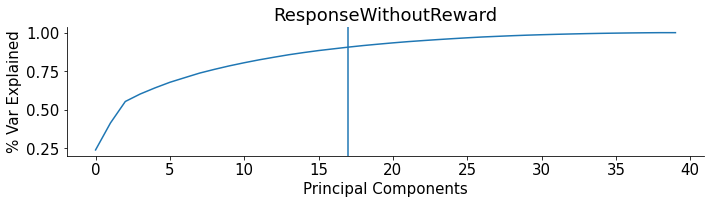

(40, 40)
22


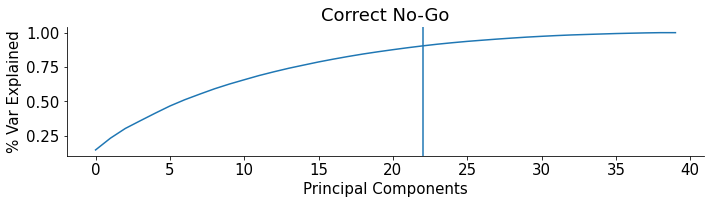

(40, 40)
22


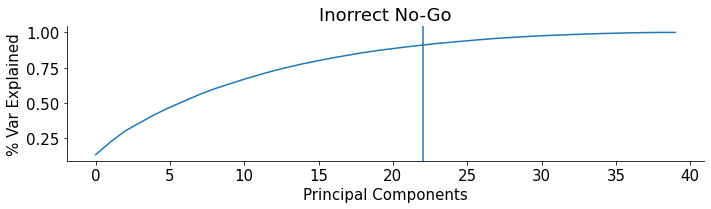

In [67]:
# do PCA on "choice" period
plt.subplot(4,1,1)
resprewPCschoice, fitresprewchoice, Wresprewchoice = doPCAonRegions(regAvgZRespRew[:, 51:91], 'ResponseWithReward')
plt.show()

plt.subplot(4,1,2)
respnorewPCschoice, fitrespnorewchoice, Wrespnorewchoice = doPCAonRegions(regAvgZRespNoRew[:, 51:91], 'ResponseWithoutReward')
plt.show()

plt.subplot(4,1,3)
nogocorrPCschoice, fitnogocorrchoice, Wnogocorrchoice = doPCAonRegions(regAvgZNoGoCorr[:, 51:91], 'Correct No-Go')
plt.show()

plt.subplot(4,1,4)
nogoincorrPCschoice, fitnogoincorrchoice, Wnogoincorrchoice = doPCAonRegions(regAvgZNoGoIncorr[:, 51:91], 'Inorrect No-Go')
plt.show()

In [31]:
#plot the relevant PCs from the transformed data
def plotDataPCs(dataFit, PCsToUse, title):
    plt.plot(np.arange(0,250), dataFit[:,:PCsToUse])
    plt.title(title)
    plt.ylabel('Activity in Each Component')
    plt.xlabel('Time (samples)')

In [95]:
#find which features (regions) are contributing most to the PCs
def findContribFeatures(W, PCs, thresh, allregions):
    ROIs = np.empty(0) #create empty vector to store ROI names

    #go through each component, find feature weights that exceed threshold
    for p in range(0,PCs):
        #get the current set of feature weights
        featureweights = W[p, :]
        #find the indices of the weights that exceed threshold
        ROIs = np.append(ROIs, np.where(np.abs(featureweights) > thresh))

    #convert list of indices to int
    ROIidx = ROIs.astype(int)
    
    #get a list of region names for each index
    reg_list = set([allregions[i] for i in ROIidx])
    print(reg_list)
    
    #plot feature weights for relevant PCs for each region (feature)
    plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(Wresprew[:resprewPCs, :], cmap='hot')
    plt.colorbar()

    #return list of regions
    return reg_list


In [73]:
#project PCs from choice period onto entire trial trace and plot
def projectDataOnPCs(data, W, PCsToUse, title):
    #transform data according to the feature weights for relevant PCs only
    transData = W[:PCsToUse, :] @ data
    plt.plot(np.arange(0,250), transData.T)
    plt.title(title)
    plt.ylabel('Activity in Each Component')
    plt.xlabel('Time (samples)')
    return transData

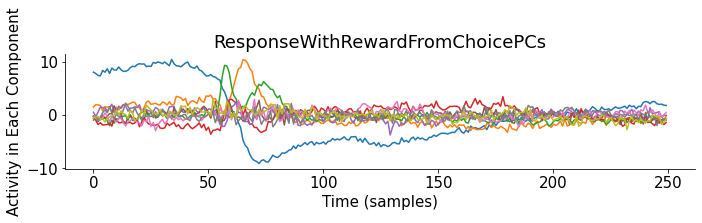

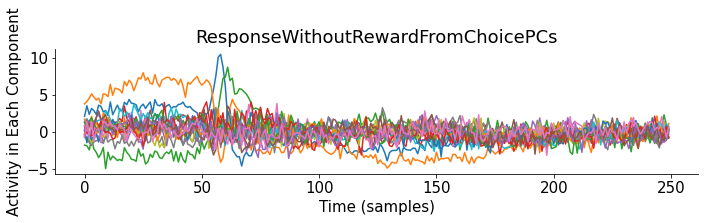

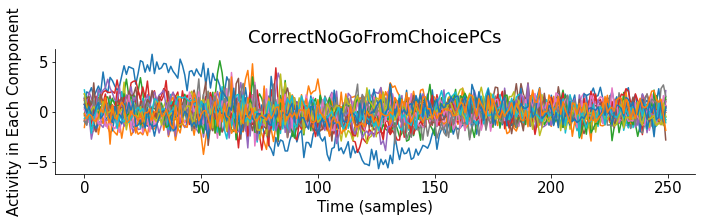

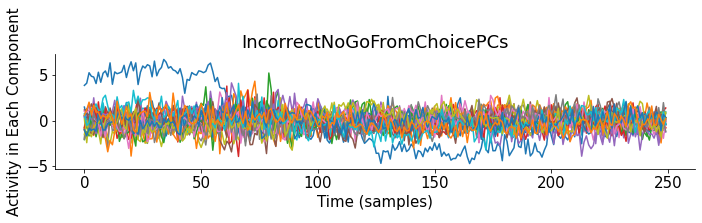

In [93]:
#plot data fit to "choice PCs" for each trial type
plt.subplot(4,1,1)
resprewProjChoicePCs = projectDataOnPCs(regAvgZRespRew, Wresprewchoice, resprewPCschoice, 'ResponseWithRewardFromChoicePCs')
plt.show()

plt.subplot(4,1,2)
respnorewProjChoicePCs = projectDataOnPCs(regAvgZRespNoRew, Wrespnorewchoice, respnorewPCschoice, 'ResponseWithoutRewardFromChoicePCs')
plt.show()

plt.subplot(4,1,3)
nogocorrProjChoicePCs = projectDataOnPCs(regAvgZNoGoCorr, Wnogocorrchoice, nogocorrPCschoice, 'CorrectNoGoFromChoicePCs')
plt.show()

plt.subplot(4,1,4)
nogoincorrProjChoicePCs = projectDataOnPCs(regAvgZNoGoIncorr, Wnogoincorrchoice, nogoincorrPCschoice, 'IncorrectNoGoFromChoicePCs')
plt.show()

{'DP', 'SSs', 'VISl', 'VISrl', 'CA2', 'SCs', 'EP', 'CL', 'LSr', 'MEA', 'VISp', 'BLA', 'NB', 'VISpm', 'BMA', 'LS', 'LH'}
{'COA', 'PT', 'DP', 'SPF', 'ORBm', 'VISl', 'CA', 'PL', 'PIR', 'CA2', 'VAL', 'LS', 'ILA', 'LSr', 'MEA', 'BLA', 'VISpm', 'ACB', 'PAG', 'LH'}
{'DP', 'CA3', 'CA', 'VISrl', 'VISpm', 'PIR', 'PL', 'EP', 'ILA', 'MD', 'LS', 'LSc', 'MEA', 'OT', 'BLA', 'CA2', 'RN', 'PAG', 'LH'}
{'ORBm', 'GPe', 'ILA', 'VISp', 'ACB', 'DP', 'CA', 'SCs', 'CA1', 'VISpm', 'CA3', 'COA', 'PT', 'BLA', 'PAG', 'POST', 'POL', 'LSr', 'LSc', 'CA2', 'BMA', 'LS', 'LH'}


Text(0.5, 1.0, 'IncorrectNoGoChoiceRegions')

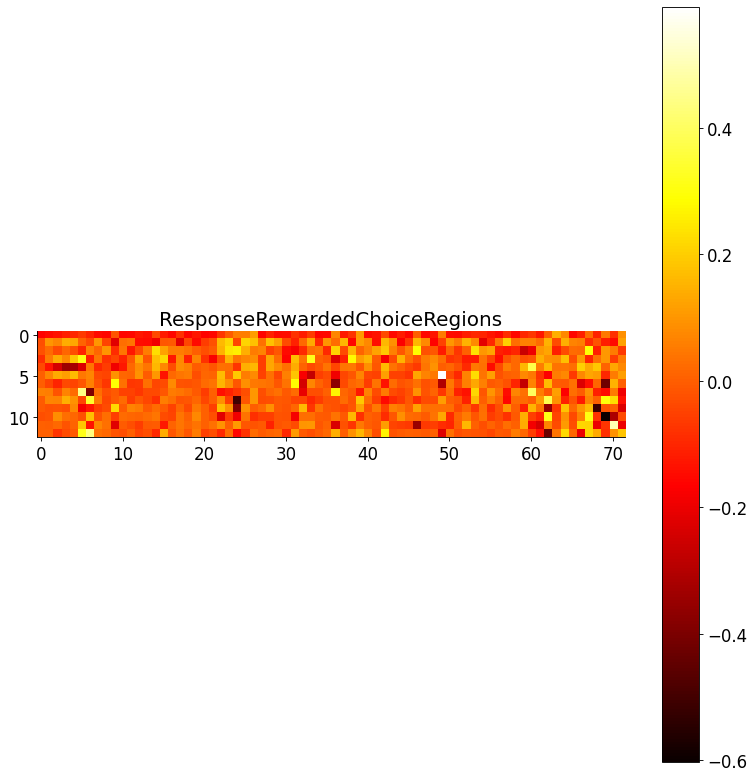

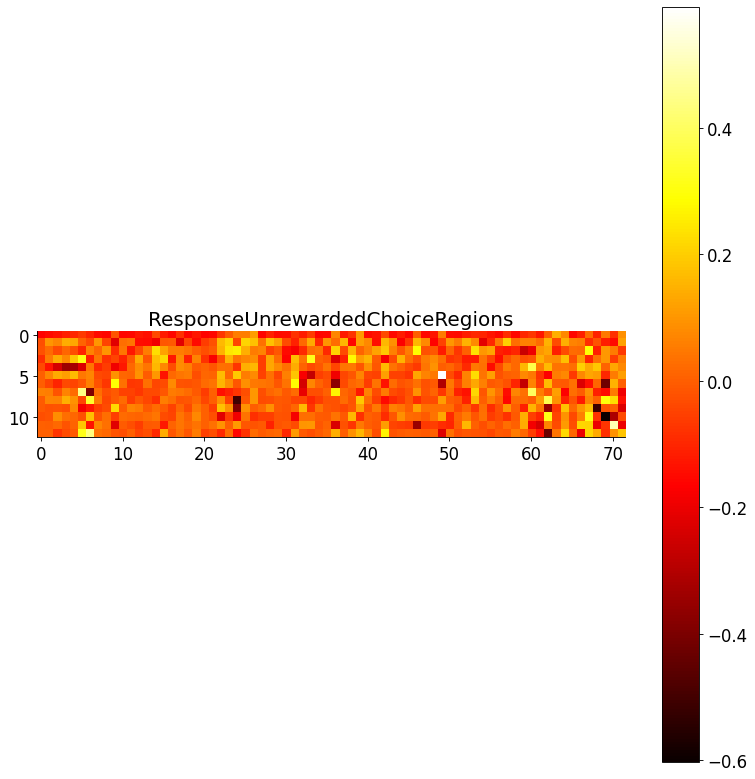

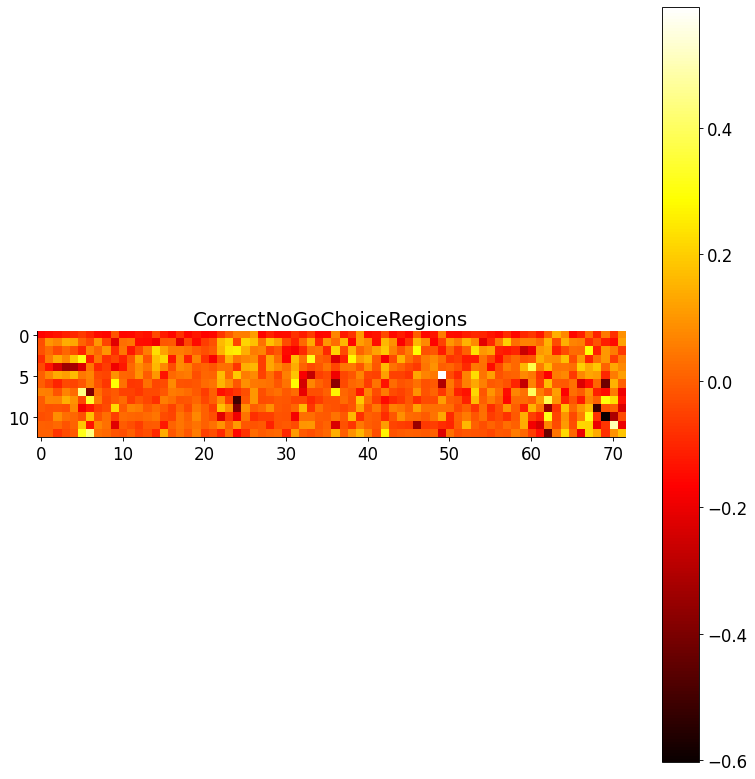

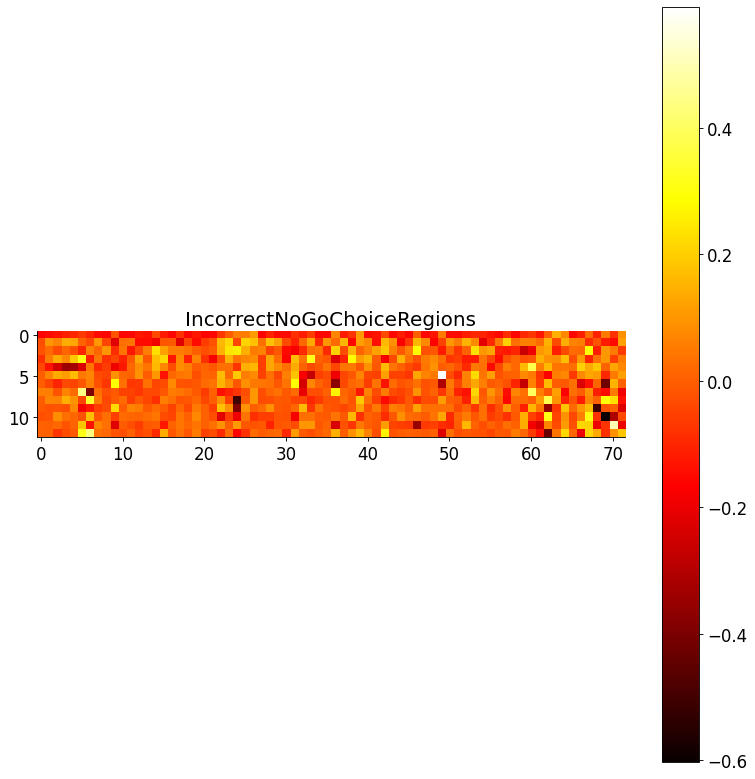

In [96]:
#find regions that contribute to choice PCs
resprewRegChoice = findContribFeatures(Wresprewchoice, resprewPCschoice, .3, allregions)
plt.title("ResponseRewardedChoiceRegions")

respnorewRegChoice = findContribFeatures(Wrespnorewchoice, respnorewPCschoice, .3, allregions)
plt.title("ResponseUnrewardedChoiceRegions")

nogocorrRegChoice = findContribFeatures(Wnogocorrchoice, nogocorrPCschoice, .3, allregions)
plt.title("CorrectNoGoChoiceRegions")

nogoincorrRegChoice = findContribFeatures(Wnogoincorrchoice, nogoincorrPCschoice, .3, allregions)
plt.title("IncorrectNoGoChoiceRegions")

In [113]:
#organize neurons recorded across session
#create a plot with session x region with neurons recorded in each bar

#variables of interest
print(sessionID.shape)
print(allLoc.shape)

#create empty matrix to store neuronN data (session x region)
neuronCounts = np.empty((sessionN, len(allregions))

#go through each session
for s in range(0,sessionN):
    currSessIdx = np.where(sessionID == s)
    currSessReg = allLoc[currSessIdx]

    #now loop through all possible regions
    for r in range(0,len(allregions)):
        currReg = allregions[r]

        #get number of neurons recorded in this region
        currNeurN = len(np.where(currSessReg==currReg))

        #add this number to the matrix
        neuronCounts[s,r] = currNeurN

SyntaxError: ignored

In [108]:
print(sessionN)

39
